# Get your check in data from Swarm

### Import Python tools and Jupyter configuration

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import json
import sqlite3
from datetime import datetime
import keys

/Users/mhustiles/.local/share/virtualenvs/notebooks-xu8v5Vvv/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
import altair as alt
import altair_latimes as lat

alt.themes.register("latimes", lat.theme)
alt.themes.enable("stiles")

ThemeRegistry.enable('latimes')

In [4]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = None
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

---

In [5]:
today = datetime.today().strftime("%Y-%m-%d")

### Get the data using this tool from [Swarm-to-SQLite](https://github.com/dogsheep/swarm-to-sqlite)

In [6]:
### Pass in your oauth_token from what you store in keys.py

In [8]:
# !swarm-to-sqlite data/raw/checkins.db --token={keys.TOKEN}

### Read the sqlite database we downloaded

In [9]:
import sqlite3

# Create a SQL connection to our SQLite database
cnx = sqlite3.connect("data/raw/checkins.db")

### Create dataframes for various tables in the DB

In [10]:
venues = pd.read_sql_query("SELECT * FROM venues", cnx)
checkins = pd.read_sql_query("SELECT * FROM checkins", cnx)
categories = pd.read_sql_query("SELECT * FROM categories", cnx)
categories_venues = pd.read_sql_query("SELECT * FROM categories_venues", cnx)

### Merge categories and venues so you can attach categories to the venues in your checkins

In [11]:
category_lookup = pd.merge(
    categories_venues, categories, left_on="categories_id", right_on="id"
)

In [12]:
venue_lookup = pd.merge(categories_venues, venues, left_on="venues_id", right_on="id")

### Merge checkins and venues

In [13]:
src = pd.merge(checkins, venue_lookup, left_on="venue", right_on="id")

In [14]:
df = pd.merge(src, category_lookup, on="venues_id")

### We don't need all the fields

In [15]:
df_slim = df[
    [
        "id_x",
        "timeZoneOffset",
        "isMayor",
        "created",
        "name_x",
        "venue",
        "address",
        "crossStreet",
        "postalCode",
        "city",
        "state",
        "country",
        "latitude",
        "longitude",
        "pluralName",
    ]
].copy()

In [16]:
df_slim.sort_values("created", ascending=False).head()

,id_x,timeZoneOffset,isMayor,created,name_x,venue,address,crossStreet,postalCode,city,state,country,latitude,longitude,pluralName
115,61479ba7a46c662715e1cc33,-420,0,2021-09-19T20:20:55,Del Rey,4d27f64f467d6ea88416c295,None,None,90066,Los Angeles,CA,United States,33.989248,-118.415931,Neighborhoods
117,61479274b5dd4257688ca9d3,-420,0,2021-09-19T19:41:40,Kenneth Hahn State Park La Brea Trail,50452241e4b0d4331289cf7c,None,None,90008,Los Angeles,CA,United States,34.011449,-118.365974,Trails
121,61478d58b5ec670a9b5010ae,-420,0,2021-09-19T19:19:52,Carl's Jr.,4c130215a5eb76b04156bfb7,5800 Obama Blvd,at La Cienega Blvd,90016,Los Angeles,CA,United States,34.021453,-118.372834,Fast Food Restaurants
122,61477b37a8c6976358bfcc9d,-420,0,2021-09-19T18:02:31,Natural History Museum of Los Angeles County,4a485cdcf964a520b5aa1fe3,900 Exposition Blvd,at Vermont Ave,90007,Los Angeles,CA,United States,34.016829,-118.288829,Museums
123,6147706b9d3a8e24a1012a28,-420,0,2021-09-19T17:16:27,Del Rey Optometry,4e0ce7cba809a0a62eb5309c,4266 Lincoln Blvd,Maxella,90292,Marina del Rey,CA,United States,33.986375,-118.443576,Optical Shops


### Clean up the dates

In [17]:
df_slim["date"] = pd.to_datetime(df_slim["created"], format="%Y-%m-%d")

In [18]:
df_slim["date"] = pd.to_datetime(df_slim["date"].dt.strftime("%Y-%m-%d"))

### Get segments of dates in case we need them for grouping

In [19]:
df_slim["year"] = df_slim["date"].dt.year.astype(str)
df_slim["quarter"] = df_slim["date"].dt.quarter.astype(str)
df_slim["day"] = df_slim["date"].dt.day.astype(str)
df_slim["month"] = df_slim["date"].dt.month.astype(str)
df_slim["weekday"] = df_slim["date"].dt.day_name()
df_slim["monthname"] = df_slim["date"].dt.month_name()
df_slim["monthday"] = df_slim["date"].dt.strftime("%m-%d")
df_slim["monthyear"] = df_slim["date"].dt.strftime("%m-%Y")

### Clean up columns

In [20]:
df_slim.columns = df_slim.columns.str.lower()

In [21]:
df_slim.rename(columns={"id_x": "checkinid", "name_x": "place"}, inplace=True)

---

### Change over time

In [22]:
places_time_grouped = (
    df_slim.groupby(["year"]).agg({"checkinid": "count"}).reset_index()
)

In [23]:
places_time_grouped.rename(columns={"checkinid": "count"}, inplace=True)

In [24]:
places_time_grouped.head(20)

,year,count
0,2010,292
1,2011,538
2,2012,1131
3,2013,686
4,2014,293
5,2015,239
6,2016,419
7,2017,411
8,2018,407
9,2019,624


In [25]:
alt.Chart(places_time_grouped).mark_bar().encode(x="year", y="count").properties(
    width=600, height=400
)

alt.Chart(...)

---

### Venue types

In [26]:
df_slim.sort_values("created", ascending=False).head()

,checkinid,timezoneoffset,ismayor,created,place,venue,address,crossstreet,postalcode,city,state,country,latitude,longitude,pluralname,date,year,quarter,day,month,weekday,monthname,monthday,monthyear
115,61479ba7a46c662715e1cc33,-420,0,2021-09-19T20:20:55,Del Rey,4d27f64f467d6ea88416c295,None,None,90066,Los Angeles,CA,United States,33.989248,-118.415931,Neighborhoods,2021-09-19,2021,3,19,9,Sunday,September,09-19,09-2021
117,61479274b5dd4257688ca9d3,-420,0,2021-09-19T19:41:40,Kenneth Hahn State Park La Brea Trail,50452241e4b0d4331289cf7c,None,None,90008,Los Angeles,CA,United States,34.011449,-118.365974,Trails,2021-09-19,2021,3,19,9,Sunday,September,09-19,09-2021
121,61478d58b5ec670a9b5010ae,-420,0,2021-09-19T19:19:52,Carl's Jr.,4c130215a5eb76b04156bfb7,5800 Obama Blvd,at La Cienega Blvd,90016,Los Angeles,CA,United States,34.021453,-118.372834,Fast Food Restaurants,2021-09-19,2021,3,19,9,Sunday,September,09-19,09-2021
122,61477b37a8c6976358bfcc9d,-420,0,2021-09-19T18:02:31,Natural History Museum of Los Angeles County,4a485cdcf964a520b5aa1fe3,900 Exposition Blvd,at Vermont Ave,90007,Los Angeles,CA,United States,34.016829,-118.288829,Museums,2021-09-19,2021,3,19,9,Sunday,September,09-19,09-2021
123,6147706b9d3a8e24a1012a28,-420,0,2021-09-19T17:16:27,Del Rey Optometry,4e0ce7cba809a0a62eb5309c,4266 Lincoln Blvd,Maxella,90292,Marina del Rey,CA,United States,33.986375,-118.443576,Optical Shops,2021-09-19,2021,3,19,9,Sunday,September,09-19,09-2021


In [27]:
venues_grouped = (
    df_slim.groupby(["pluralname"])
    .agg({"checkinid": "count"})
    .reset_index()
    .sort_values("checkinid", ascending=False)
)

In [28]:
venues_grouped.rename(columns={"checkinid": "count"}, inplace=True)

In [29]:
venues_grouped.head()

,pluralname,count
216,Offices,606
73,Coffee Shops,435
5,Airports,334
194,Metro Stations,232
113,Event Spaces,210


---

### Countries

In [30]:
countries_grouped = (
    df_slim.groupby(["country"])
    .agg({"checkinid": "count"})
    .reset_index()
    .sort_values("checkinid", ascending=False)
)

In [31]:
countries_grouped.rename(columns={"checkinid": "count"}, inplace=True)

In [32]:
countries_grouped.head(20)

,country,count
26,United States,4098
21,South Korea,1053
23,Taiwan,55
14,Japan,29
11,Ireland,29
3,China,23
19,Poland,16
10,Indonesia,16
17,Netherlands,13
4,Costa Rica,12


---

### Make it a geodataframe

In [33]:
gdf = gpd.GeoDataFrame(
    df_slim, geometry=gpd.points_from_xy(df_slim.longitude, df_slim.latitude)
)

<AxesSubplot:>

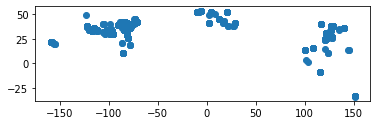

In [34]:
gdf.plot()

### Export

In [35]:
gdf.to_file("data/processed/checkins_geo.geojson", driver="GeoJSON")